# Tutorial Notebook for `GeneralizedChartParsing.jl`

In [1]:
# import the package
using GeneralizedChartParsing

## 1. Calculating the number of binary trees

To give a simple first demonstration of how to use this library,
we calculate the number of binary trees with `n` leafs
using a simple context-free grammar.

In [2]:
# generate a grammar from a string of rules
g = grammar_from_string("S --> S S | a")

# define length of the sequence
n = 10

# parse a sequence of `a`s; get a named tuple of score values
scores = parse(g, fill("a", n))

Dict{String,NamedTuple{(:count,),Tuple{Int64}}} with 1 entry:
  "S" => (count = 4862,)

In [3]:
# the number of parse trees is stored in the `count` value of the start symbol
scores["S"].count

4862

The first line loads the package. The second line creates a grammar object from the string `"S --> S S | a"`. This grammar contains two rules, the binary rule `S --> S S` and the terminal rule `S --> a`. 

In [4]:
g.binary_rules

1-element Array{Function,1}:
 S --> S S

In [5]:
g.terminal_rules

1-element Array{Function,1}:
 S --> a

The function `grammar_from_string` accepts also multiline strings. The first left-hand side of the first rule in the string is taken as the start symbol of the grammar.

The function `parse` takes a grammar and a sequence of terminal symbols and returns a dictionary mapping start symbols of the grammar (here we have only one start symbol) to the number of parse trees that generate the input sequence. We can extract this number and get the answer that there are 4862 different binary trees with 10 leafs.

In general, the dictionary returned by the `parse` function maps the start symbols of the grammar to their semiring values using the score functions of the grammar. If a sequence is not parsable, zero is returned.

In [6]:
parse(g, fill("b", 3))

Dict{String,NamedTuple{(:count,),Tuple{Int64}}} with 1 entry:
  "S" => (count = 0,)

## 2. Plotting parse trees

In [7]:
# enumerate all parse trees as score values
g2 = add_score(g, :enum_forest, enum_forest_score)

# parse a sequence of four `a`s
score = parse(g2, fill("a", 4))["S"]

# convert the score to a list of parse trees, displayed as bracked string
trees = tree_structs(g, score.enum_forest)

5-element Array{GeneralizedChartParsing.Trees.Tree{Any},1}:
 [S[S[a]][S[S[a]][S[S[a]][S[a]]]]]
 [S[S[a]][S[S[S[a]][S[a]]][S[a]]]]
 [S[S[S[a]][S[a]]][S[S[a]][S[a]]]]
 [S[S[S[a]][S[S[a]][S[a]]]][S[a]]]
 [S[S[S[S[a]][S[a]]][S[a]]][S[a]]]

In [8]:
# TikzQTrees can be installed via 
# using Pkg
# Pkg.add("https://github.com/dharasim/TikzQTrees.jl")

using TikzQTrees

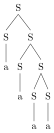

In [9]:
# plot the first parse tree using latex and tikz
TikzQTree(trees[1])

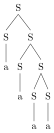

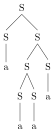

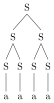

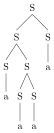

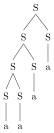

In [10]:
# plot all parse trees
foreach(trees) do tree
    display(TikzQTree(tree))
end

## 3. Sampling parse trees from a compact forest representation

In [11]:
# sample random rule probabilities from a flat dirichlet prior and 
# add compact forest representation as score value 
g3 = add_forest_score(add_random_prob_score(g, :count), :prob)

# parse sequece
forest = parse(g3, fill("a", 10))["S"].forest;

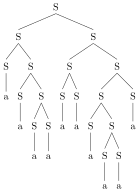

In [12]:
rand(forest) |>                # get random tree iterator 
    collect |>                 # collect rule applications of a random tree
    t -> tree_struct(g3, t) |> # convert rule applications to tree representation
    TikzQTree                  # wrap tree into a TikzQTree for visualization

## 4. The canonical `a^n b^n` example

In [13]:
g4 = let g = grammar_from_string(
        """
        S --> A X
        X --> S B | b
        A --> a
        B --> b
        """
    )
    add_score(g, :enum_forest, enum_forest_score)
end

forest = parse(g4, split("a a a a b b b b"))["S"].enum_forest

GeneralizedChartParsing.EnumForest(Array{Tuple{Int64,Int64},1}[[(1, 1), (3, 4), (2, 2), (1, 1), (3, 4), (2, 2), (1, 1), (3, 4), (2, 2), (1, 1), (3, 4), (2, 3), (4, 5), (4, 5), (4, 5)]])

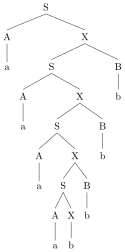

In [14]:
tree_structs(g4, forest)[1] |> TikzQTree

## 5. Using functions as meta rules
Standard context-free rules can be combined into partial functions, also known as meta rules. The follwing gives an example of a grammar using meta rules. This grammar generates sequences of numbers between 1 and 10 that start with 1 and either repeat the current number, count up by 1, or jump down.

In [15]:
categories       = collect(1:10)
start_categories = [1]

double(x)        = (x, x)
countup(x)       = x <= 9 ? (x, x+1) : nothing # a rule function returns nothing if it is not
terminate(x)     = string(x)                   # applicable to the input category

binary_rules     = [double, countup]
terminal_rules   = [terminate]
depcomp          = identity    # the dependent components of a category are used 
                               # to share probability mass across categories 

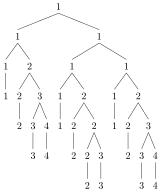

In [16]:
g5 = add_score(
    Grammar(categories, start_categories, binary_rules, terminal_rules, depcomp),
    :enum_forest_score,
    enum_forest_score
)

enumerated_forest = parse(g5, split("1 2 3 4 1 2 2 3 1 2 3 4"))[1].enum_forest_score
tree = tree_structs(g5, enumerated_forest)[1] |> TikzQTree

## 6. Application in Digital and Computational Musicology
Software closely related to this package was used in the paper

Harasim, Daniel and Rohrmeier, Martin and O'Donnell, Timothy J. (2018, to appear in September). A Generalized Parsing Framework for Generative Models of Harmonic Syntax. In *Proceedings of the International Conference on Music Information Retrieval (ISMIR)*.

That paper also describes the theory of using partial rewrite functions as rules by defining the formalism of *Abstract context-free grammars*.

## Funding
This project has received funding from the European Research Council (ERC) under the European Union’s Horizon 2020 research and innovation programme (GA Nr 760081) as well as the Natural Sciences and Engineering Research Council of Canada (NSERC) and the Zukunftskonzept at TU Dresden funded by the Exzellenzinitiative of the Deutsche Forschungsgemeinschaft. We thank Claude Latour for supporting this research through the Latour Chair in Digital Musicology.